In [1]:
!pip install -q pmdarima

In [3]:
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
warnings.filterwarnings('ignore')

In [5]:
df = pd.read_csv("E:\index.csv")
df["date"] = pd.to_datetime(df["date"])

date_range = pd.date_range(start=df["date"].min(), end=df["date"].max())
complete_dates = pd.DataFrame(date_range, columns=["date"])
df_by_date = df.groupby("date").agg({"money": ["count"]}).reset_index()
df_by_date.columns = ["date", "cups"]
df_complete = pd.merge(complete_dates, df_by_date, on="date", how="left")
df_complete.fillna(0, inplace=True)

In [7]:
test_size = 7

train_size = df_complete.shape[0] - test_size

df_train = df_complete.iloc[:train_size]
df_test = df_complete.iloc[train_size:]

metrics = []

(0.0, 40.95)

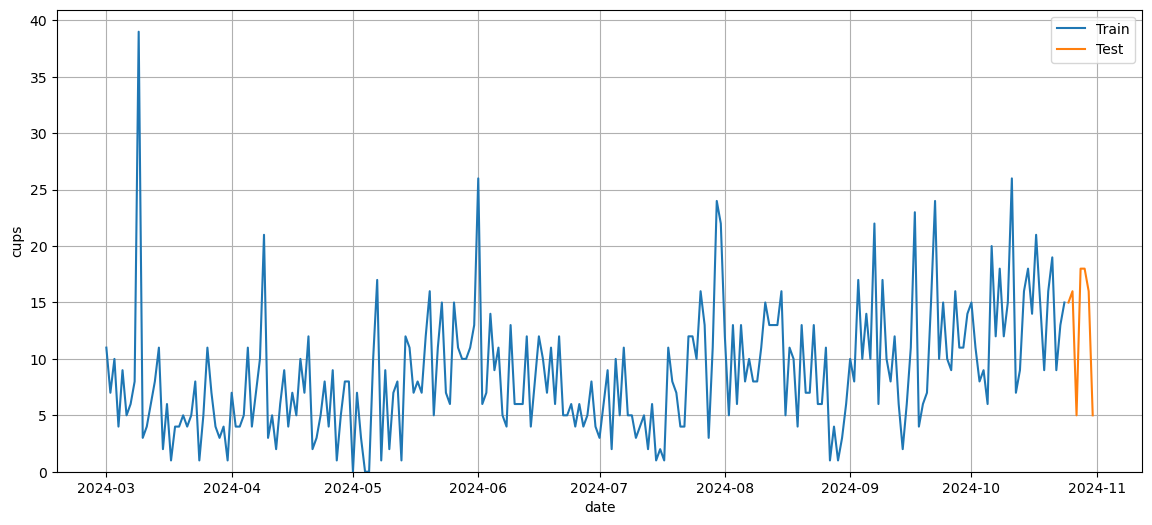

In [9]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="cups", x="date", label="Train")
sns.lineplot(data=df_test, y="cups", x="date", label="Test")
plt.grid()
plt.ylim(0)

In [11]:
# ARIMA

In [13]:
p, d, q = 5, 0, 5
model = ARIMA(df_train['cups'], order=(p, d, q))
model_fit = model.fit()

In [15]:
test_predictions = model_fit.forecast(steps=len(df_test)).values
df_test["arima_pred"] = test_predictions

(0.0, 40.95)

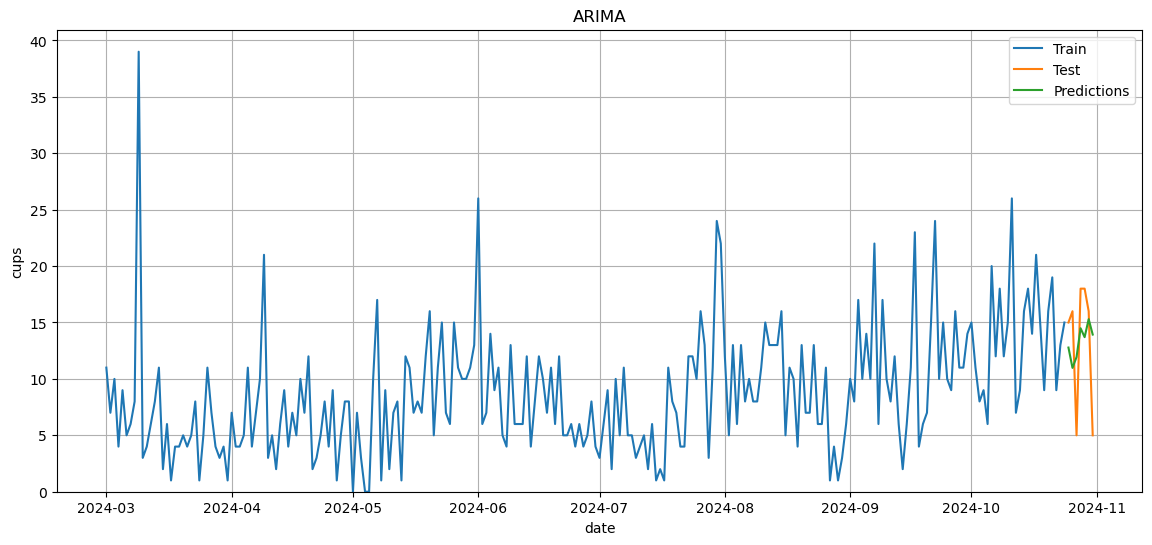

In [17]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="cups", x="date", label="Train")
sns.lineplot(data=df_test, y="cups", x="date", label="Test")
sns.lineplot(data=df_test, y="arima_pred", x="date", label="Predictions")
plt.title('ARIMA')
plt.grid()
plt.ylim(0)

In [19]:
df_test

,date,cups,arima_pred
238,2024-10-25,15.0,12.778211
239,2024-10-26,16.0,10.975889
240,2024-10-27,5.0,11.936317
241,2024-10-28,18.0,14.490657
242,2024-10-29,18.0,13.700033
243,2024-10-30,16.0,15.296202
244,2024-10-31,5.0,13.930362


In [21]:
mae = mean_absolute_error(df_test["cups"], test_predictions)
metrics.append({"model": "ARIMA", "mae": mae})
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 4.517955401522251


In [ ]:
# SARIMAX

In [23]:
p, d, q = 5, 0, 5
P, D, Q, m = 1, 1, 1, 7
model = SARIMAX(df_train['cups'], order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit()

In [25]:
test_predictions = model_fit.forecast(steps=len(df_test)).values
df_test["sarimax_pred"] = test_predictions

(0.0, 40.95)

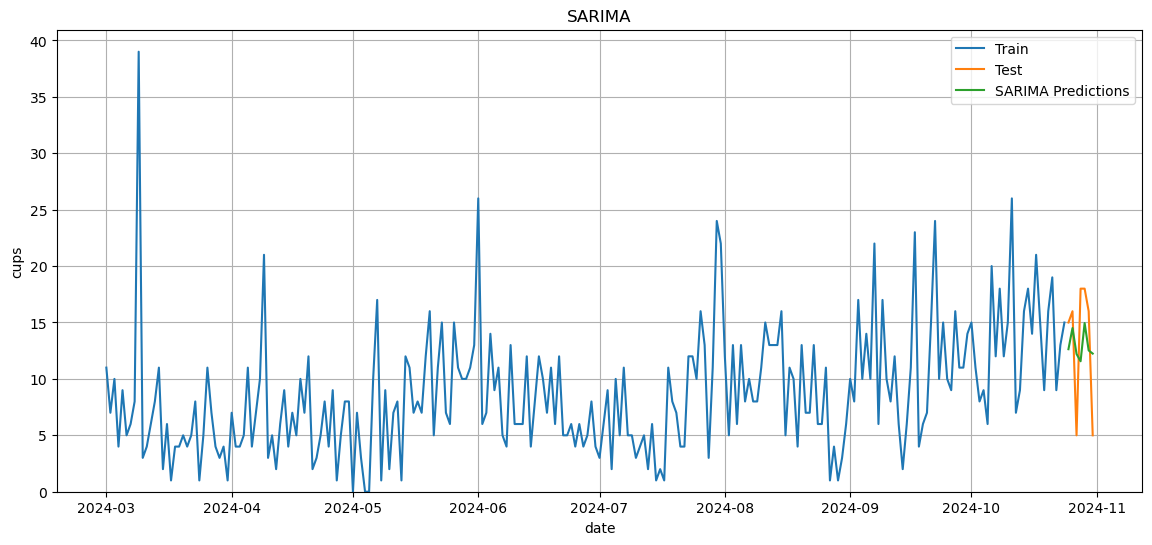

In [27]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="cups", x="date", label="Train")
sns.lineplot(data=df_test, y="cups", x="date", label="Test")
sns.lineplot(data=df_test, y="sarimax_pred", x="date", label="SARIMA Predictions")
plt.title('SARIMA')
plt.grid()
plt.ylim(0)

In [29]:
df_test

,date,cups,arima_pred,sarimax_pred
238,2024-10-25,15.0,12.778211,12.632561
239,2024-10-26,16.0,10.975889,14.509880
240,2024-10-27,5.0,11.936317,12.206782
241,2024-10-28,18.0,14.490657,11.562788
242,2024-10-29,18.0,13.700033,14.950477
243,2024-10-30,16.0,15.296202,12.523120
244,2024-10-31,5.0,13.930362,12.243493


In [31]:
mae = mean_absolute_error(df_test["cups"], test_predictions)
metrics.append({"model": "SARIMAX", "mae": mae})
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 4.467349709275139


In [33]:
# Auto ARIMA

In [35]:
model = auto_arima(
    df_train['cups'],
    seasonal=False, 
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1457.389, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1583.572, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1524.879, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1451.765, Time=0.28 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1581.573, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1453.748, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1453.747, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1455.707, Time=0.31 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=1450.166, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=1452.162, Time=0.09 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=1452.161, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=1522.885, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1454.125, Time=0.21 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 2.049 seconds


In [37]:
test_predictions = model.predict(n_periods=len(df_test)).values
df_test["auto_arima_pred"] = test_predictions

(0.0, 40.95)

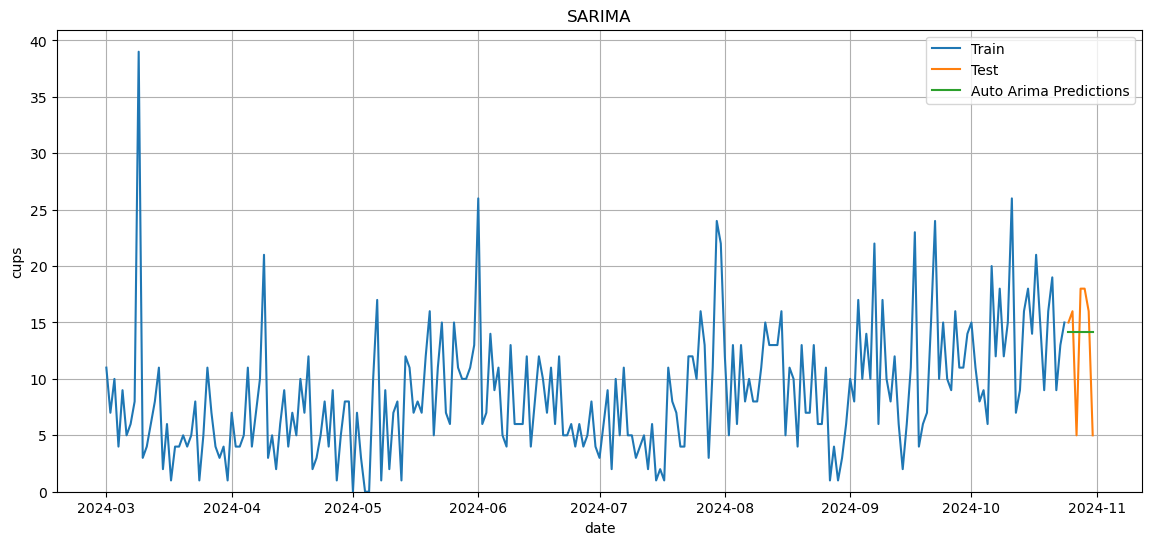

In [39]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="cups", x="date", label="Train")
sns.lineplot(data=df_test, y="cups", x="date", label="Test")
sns.lineplot(data=df_test, y="auto_arima_pred", x="date", label="Auto Arima Predictions")
plt.title('SARIMA')
plt.grid()
plt.ylim(0)

In [41]:
df_test

,date,cups,arima_pred,sarimax_pred,auto_arima_pred
238,2024-10-25,15.0,12.778211,12.632561,14.160601
239,2024-10-26,16.0,10.975889,14.509880,14.160601
240,2024-10-27,5.0,11.936317,12.206782,14.160601
241,2024-10-28,18.0,14.490657,11.562788,14.160601
242,2024-10-29,18.0,13.700033,14.950477,14.160601
243,2024-10-30,16.0,15.296202,12.523120,14.160601
244,2024-10-31,5.0,13.930362,12.243493,14.160601


In [43]:
mae = mean_absolute_error(df_test["cups"], test_predictions)
metrics.append({"model": "Auto ARIMA", "mae": mae})
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 4.35974242023956


In [45]:
# Auto SARIMAX

In [47]:
model = auto_arima(
    df_train['cups'],
    seasonal=True, 
    m=7,
    trace=True, 
    error_action='ignore', 
    suppress_warnings=True,
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=1460.224, Time=1.14 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=1583.572, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=1525.794, Time=0.20 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=1453.012, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=1581.573, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=1451.765, Time=0.07 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=1452.988, Time=0.15 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=1454.941, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[7] intercept   : AIC=1453.748, Time=0.14 sec
 ARIMA(0,1,2)(0,0,0)[7] intercept   : AIC=1453.747, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=1524.879, Time=0.06 sec
 ARIMA(1,1,2)(0,0,0)[7] intercept   : AIC=1455.707, Time=0.33 sec
 ARIMA(0,1,1)(0,0,0)[7]             : AIC=1450.166, Time=0.05 sec
 ARIMA(0,1,1)(1,0,0)[7]             : AIC=1451.378, Time=0.10 sec
 ARIMA(0,1,1)(0,0,1)[7]          

In [49]:
test_predictions = model.predict(n_periods=len(df_test)).values
df_test["auto_sarimax_pred"] = test_predictions

(0.0, 40.95)

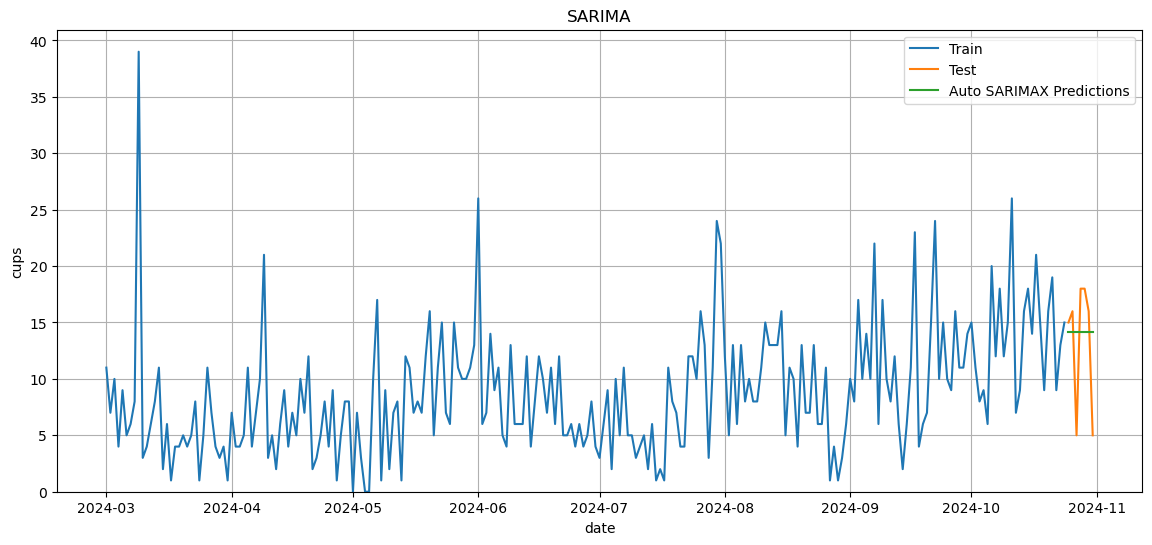

In [51]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="cups", x="date", label="Train")
sns.lineplot(data=df_test, y="cups", x="date", label="Test")
sns.lineplot(data=df_test, y="auto_sarimax_pred", x="date", label="Auto SARIMAX Predictions")
plt.title('SARIMA')
plt.grid()
plt.ylim(0)

In [53]:
df_test

,date,cups,arima_pred,sarimax_pred,auto_arima_pred,auto_sarimax_pred
238,2024-10-25,15.0,12.778211,12.632561,14.160601,14.160601
239,2024-10-26,16.0,10.975889,14.509880,14.160601,14.160601
240,2024-10-27,5.0,11.936317,12.206782,14.160601,14.160601
241,2024-10-28,18.0,14.490657,11.562788,14.160601,14.160601
242,2024-10-29,18.0,13.700033,14.950477,14.160601,14.160601
243,2024-10-30,16.0,15.296202,12.523120,14.160601,14.160601
244,2024-10-31,5.0,13.930362,12.243493,14.160601,14.160601


In [55]:
mae = mean_absolute_error(df_test["cups"], test_predictions)
metrics.append({"model": "Auto SARIMAX", "mae": mae})
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 4.35974242023956


In [57]:
# Custom Auto ARIMA

In [59]:
train_data, val_data = train_test_split(df_train['cups'], test_size=0.2, shuffle=False)

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

tmp_metrics = []

for p, d, q in itertools.product(p_values, d_values, q_values):
    try:
        model = ARIMA(train_data, order=(p, d, q))
        model_fit = model.fit()

        val_predictions = model_fit.forecast(steps=len(val_data)).values
        val_data_pred = pd.Series(val_predictions, index=val_data.index)

        mae = mean_absolute_error(val_data, val_data_pred)

        tmp_metrics.append({"model": f"ARIMA({p},{d},{q})", "mae": mae})
        print(f'ARIMA({p},{d},{q}) - Mean Absolute Error: {mae}')
        
    except Exception as e:
        print(f"ARIMA({p},{d},{q}) failed with error: {e}")

tmp_results_df = pd.DataFrame(tmp_metrics)

best_params = tmp_results_df.loc[tmp_results_df['mae'].idxmin()]
print(f'Best parameters: {best_params["model"]}, MAE: {best_params["mae"]}')

p_best, d_best, q_best = map(int, best_params["model"][6:-1].split(","))
best_model = ARIMA(df_train['cups'], order=(p_best, d_best, q_best))
best_model_fit = best_model.fit()



ARIMA(0,0,0) - Mean Absolute Error: 5.734652212668812
ARIMA(0,0,1) - Mean Absolute Error: 5.728220192625314
ARIMA(0,0,2) - Mean Absolute Error: 5.719473792150059
ARIMA(0,0,3) - Mean Absolute Error: 5.724229757481193
ARIMA(0,0,4) - Mean Absolute Error: 5.672673265856711
ARIMA(0,0,5) - Mean Absolute Error: 5.670346876702464
ARIMA(0,1,0) - Mean Absolute Error: 4.708333333333333
ARIMA(0,1,1) - Mean Absolute Error: 4.908655536771978
ARIMA(0,1,2) - Mean Absolute Error: 4.925729238073328
ARIMA(0,1,3) - Mean Absolute Error: 4.877722473206297
ARIMA(0,1,4) - Mean Absolute Error: 4.8573458639330935
ARIMA(0,1,5) - Mean Absolute Error: 4.899072259766085
ARIMA(1,0,0) - Mean Absolute Error: 5.723830973974311
ARIMA(1,0,1) - Mean Absolute Error: 5.618811343020146
ARIMA(1,0,2) - Mean Absolute Error: 5.618462502619718
ARIMA(1,0,3) - Mean Absolute Error: 5.6325153922670195
ARIMA(1,0,4) - Mean Absolute Error: 5.622826321286532
ARIMA(1,0,5) - Mean Absolute Error: 5.629487562026337
ARIMA(1,1,0) - Mean Absolu

In [61]:
df_test

,date,cups,arima_pred,sarimax_pred,auto_arima_pred,auto_sarimax_pred
238,2024-10-25,15.0,12.778211,12.632561,14.160601,14.160601
239,2024-10-26,16.0,10.975889,14.509880,14.160601,14.160601
240,2024-10-27,5.0,11.936317,12.206782,14.160601,14.160601
241,2024-10-28,18.0,14.490657,11.562788,14.160601,14.160601
242,2024-10-29,18.0,13.700033,14.950477,14.160601,14.160601
243,2024-10-30,16.0,15.296202,12.523120,14.160601,14.160601
244,2024-10-31,5.0,13.930362,12.243493,14.160601,14.160601


In [63]:
test_predictions = model_fit.forecast(steps=len(df_test)).values
df_test["custom_auto_arima_pred"] = test_predictions

(0.0, 40.95)

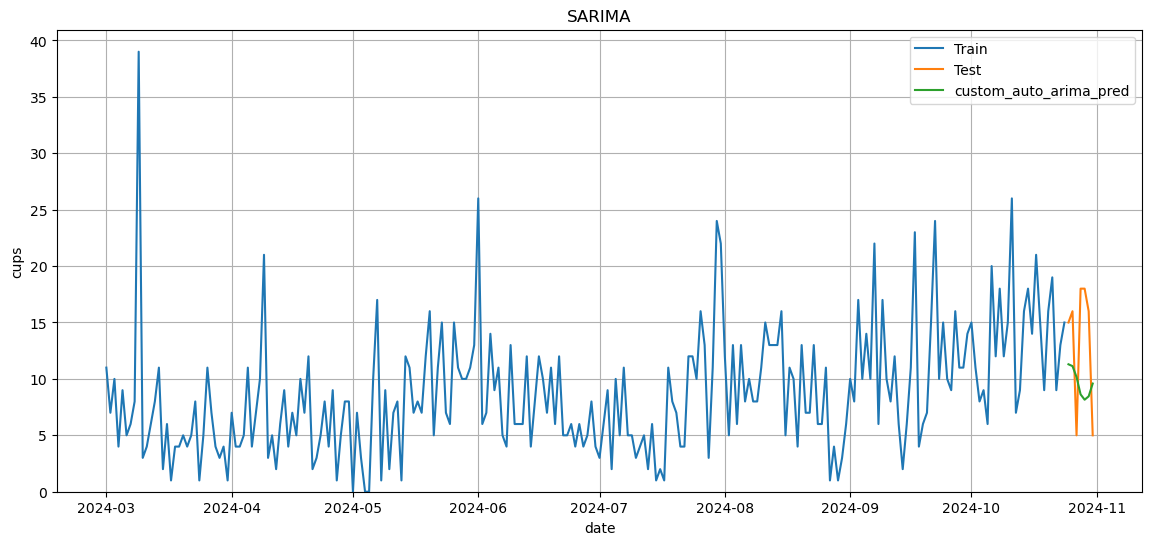

In [65]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="cups", x="date", label="Train")
sns.lineplot(data=df_test, y="cups", x="date", label="Test")
sns.lineplot(data=df_test, y="custom_auto_arima_pred", x="date", label="custom_auto_arima_pred")
plt.title('SARIMA')
plt.grid()
plt.ylim(0)

In [67]:
df_test

,date,cups,arima_pred,sarimax_pred,auto_arima_pred,auto_sarimax_pred,custom_auto_arima_pred
238,2024-10-25,15.0,12.778211,12.632561,14.160601,14.160601,11.295561
239,2024-10-26,16.0,10.975889,14.509880,14.160601,14.160601,11.134038
240,2024-10-27,5.0,11.936317,12.206782,14.160601,14.160601,10.170939
241,2024-10-28,18.0,14.490657,11.562788,14.160601,14.160601,8.627443
242,2024-10-29,18.0,13.700033,14.950477,14.160601,14.160601,8.156361
243,2024-10-30,16.0,15.296202,12.523120,14.160601,14.160601,8.453475
244,2024-10-31,5.0,13.930362,12.243493,14.160601,14.160601,9.586781


In [69]:
mae = mean_absolute_error(df_test["cups"], test_predictions)
metrics.append({"model": "Custom Auto ARIMA", "mae": mae})
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 6.441548810070246


In [71]:
# LightGBM

In [79]:
pip install lightgbm



   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   ------- -------------------------------- 0.3/1.4 MB ? eta -:--:--
   ----------------------------- ---------- 1.0/1.4 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 2.6 MB/s eta 0:00:00


In [80]:
from lightgbm import LGBMRegressor

In [83]:
FEATURES = []
    
num_lags = 3
for lag in range(1, num_lags + 1):
    df_train[f'lag_{lag}'] = df_train['cups'].shift(lag)
    FEATURES.append(f'lag_{lag}')

In [85]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop(columns=['cups']), df_train['cups'], test_size=0.2, shuffle=False)

model = LGBMRegressor(learning_rate=0.1, num_leaves=31, n_estimators=100)
model.fit(X_train[FEATURES], y_train)

val_predictions = model.predict(X_val[FEATURES])
mae = mean_absolute_error(y_val, val_predictions)
print(f'Mean Absolute Error on validation set: {mae}')

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 60
[LightGBM] [Info] Number of data points in the train set: 190, number of used features: 3
[LightGBM] [Info] Start training from score 7.757895
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

In [87]:
X_test = y_val[-num_lags:][::-1].values

test_predictions = []

for i in range(len(df_test)):
    pred = model.predict(pd.DataFrame(X_test[:num_lags].reshape(1, -1), columns=FEATURES))[0]
    
    test_predictions.append(pred)
    
    X_test = np.array([pred] + X_test.tolist())

df_test["lgbm_pred"] = test_predictions

In [89]:
df_test

,date,cups,arima_pred,sarimax_pred,auto_arima_pred,auto_sarimax_pred,custom_auto_arima_pred,lgbm_pred
238,2024-10-25,15.0,12.778211,12.632561,14.160601,14.160601,11.295561,9.693475
239,2024-10-26,16.0,10.975889,14.509880,14.160601,14.160601,11.134038,11.712154
240,2024-10-27,5.0,11.936317,12.206782,14.160601,14.160601,10.170939,10.979168
241,2024-10-28,18.0,14.490657,11.562788,14.160601,14.160601,8.627443,9.775717
242,2024-10-29,18.0,13.700033,14.950477,14.160601,14.160601,8.156361,12.071313
243,2024-10-30,16.0,15.296202,12.523120,14.160601,14.160601,8.453475,10.186982
244,2024-10-31,5.0,13.930362,12.243493,14.160601,14.160601,9.586781,10.412270


(0.0, 40.95)

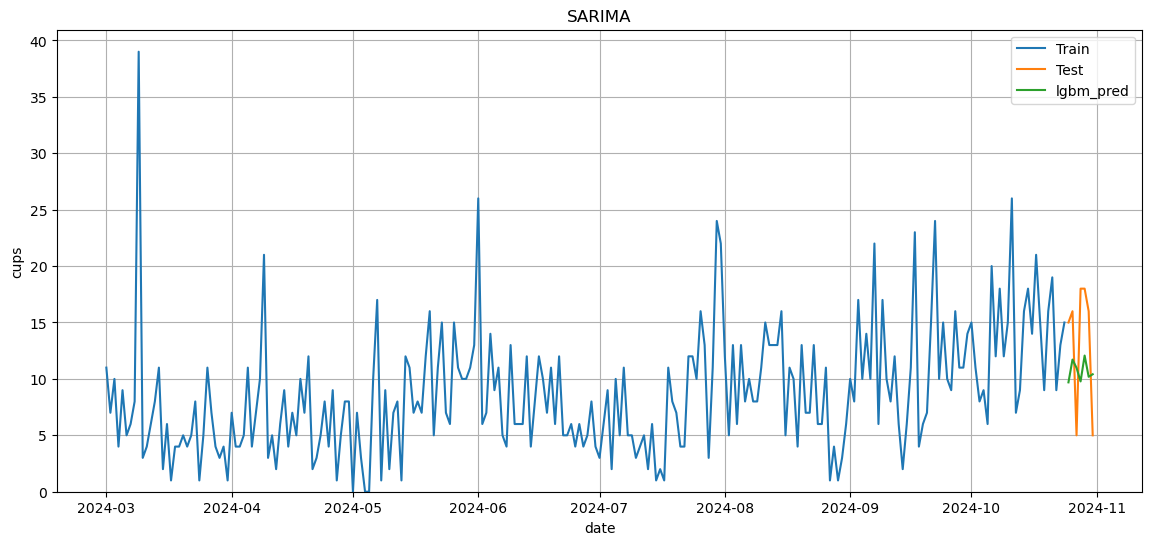

In [91]:
plt.figure(figsize=(14, 6))
sns.lineplot(data=df_train, y="cups", x="date", label="Train")
sns.lineplot(data=df_test, y="cups", x="date", label="Test")
sns.lineplot(data=df_test, y="lgbm_pred", x="date", label="lgbm_pred")
plt.title('SARIMA')
plt.grid()
plt.ylim(0)

In [93]:
mae = mean_absolute_error(df_test["cups"], test_predictions)
metrics.append({"model": "LightGBM", "mae": mae})
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 5.850256848085545


In [95]:
# Results

In [97]:
df_metrics = pd.DataFrame(metrics)

<Axes: xlabel='mae', ylabel='model'>

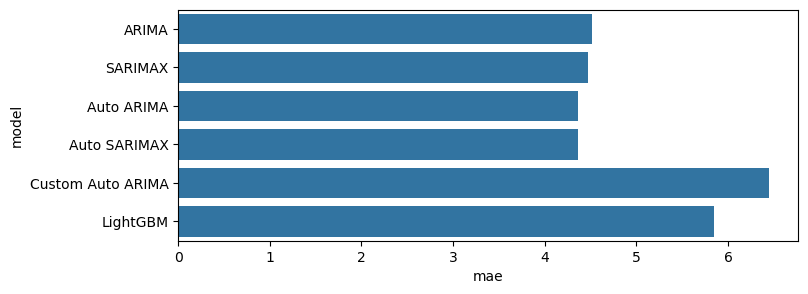

In [99]:
plt.figure(figsize=(8, 1 * df_metrics.shape[0] // 2))
sns.barplot(data=df_metrics, y="model", x="mae")